In [21]:
import pyneb as pn
import numpy as np
import matplotlib.pyplot as plt
import time

In [22]:
# This is the AAN interface. 
try:
    import ai4neb
except:
    !pip install -U git+https://github.com/morisset/AI4neb.git
    import ai4neb

# Test Atom.getTemDen

In [5]:
O3 = pn.Atom('O',3)
# Set the Artificial Neuron Network verobosity to True:
O3.ANN_inst_kwargs['verbose'] = True
N2 = pn.Atom('N',2)
N2.ANN_inst_kwargs['verbose'] = True
S2 = pn.Atom('S',2)
S2.ANN_inst_kwargs['verbose'] = True

In [6]:
# Number of data points to test the ANN option speedup. 1,000 is good to see what's happening. 10,000 starts to really rock.
N_rand = 1000
# Define some ramdom values to test the 
ratio = 150.+ 10*np.random.randn(N_rand)
den =  150.+ 10*np.random.randn(N_rand)
ratio_S2 = 1 + 0.1*np.random.randn(N_rand)
tem_S2 = 11000 + 2000 * np.random.randn(N_rand)

In [7]:
start = time.time()
resa = O3.getTemDen(ratio, den=1e2, wave1=5007, wave2=4363)

resb = O3.getTemDen(ratio, den=den, wave1=5007, wave2=4363)
resc = N2.getTemDen(ratio, den=den,
                       to_eval = '(L(6584) + L(6548)) / L(5755)')
resd = S2.getTemDen(ratio_S2, tem=11000, wave1=6716, wave2=6731)

rese = S2.getTemDen(ratio_S2, tem=tem_S2, wave1=6716, wave2=6731)
end = time.time()
print(end-start)

18.425156116485596


In [8]:
start = time.time()
res2a = O3.getTemDen(ratio, den=1e2, wave1=5007, wave2=4363, method='ANN')

res2b = O3.getTemDen(ratio, den=den, wave1=5007, wave2=4363, method='ANN')
res2c = N2.getTemDen(ratio, den=den,
                        to_eval = '(L(6584) + L(6548)) / L(5755)',
                        method='ANN')
res2d = S2.getTemDen(ratio_S2, tem=11000, wave1=6716, wave2=6731,
                         method='ANN', end_x=1e4)
res2e = S2.getTemDen(ratio_S2, tem=tem_S2, wave1=6716, wave2=6731,
                        method='ANN', end_x=1e4)

end = time.time()
print(end-start)

Instantiation. V 0.17
Training set size = 30, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 30, Test set size = 0
Training set size = 30, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 1 outputs with 30 data
RM trained, with 799 iterations. Score = 1.000
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=1e-06, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 0.2 s.
Test data scaled. Log10 applied. 
Training set size = 30, Test set size = 1000
Predicting from 2 inputs to 1 outputs using 1000 data in 0.0

In [9]:
# Compare the results
print(np.mean(resa/res2a), np.std(resa/res2a))
print(np.mean(resb/res2b), np.std(resb/res2b))
print(np.mean(resc/res2c), np.std(resc/res2c))
print(np.mean(resd/res2d), np.std(resd/res2d))
print(np.mean(rese/res2e), np.std(rese/res2e))

0.989628851618506 0.0015739650916350154
1.0029206289581216 0.0010239215279917362
1.0031256214295916 0.0007397789335735901
0.9971578858108526 0.005512895929255806
0.9960431130363838 0.008118436244891825


# Test diagnostics.getCrossTemDen

In [11]:
N = 2000
rO3 = 0.0050 * (1 + 0.6*np.random.randn(N))
rN2 = 0.0080 * (1 + 0.6*np.random.randn(N))
rS2 = 1.5 * (1 + 0.7*np.random.randn(N))

In [12]:
diags = pn.Diagnostics()

In [13]:
# Normal way: looking for the point where both diagnostics coincide:
start = time.time()
tem, den = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2)
tem2, den2 = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2)
end = time.time()
print('time for classical method: {:1f} s.'.format(end - start))

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/core/diags.py:824: RuntimeWarning: invalid value encountered in greater
  no_conv = ((abs(den_old - den) / den * 100) > tol_den) | ((abs(tem_old - tem) / tem * 100) > tol_tem)


time for classical method: 87.292322 s.


In [14]:
# Set up some parameters of the Regresor Method object
diags.ANN_inst_kwargs['random_seed'] = 43
#diags.ANN_inst_kwargs['use_log'] = False
diags.ANN_inst_kwargs['verbose'] = True

# Set up some parameters of the Analogic Neural Network
diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 30, 10)
diags.ANN_init_kwargs['activation'] = 'tanh' 
diags.ANN_n_tem = 30
diags.ANN_n_den = 30

In [15]:
# Compute Te and Ne using the ANN. Print scoring at training
start = time.time()
temNN, denNN = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
print(diags.ANN.train_score)
end = time.time()
print('time for ANN method: {:1f} s.'.format(end - start))
temNN2, denNN2 = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
print(diags.ANN.train_score)
end2 = time.time()
print('time for ANN method: {:1f} s.'.format(end2 - end))

Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
RM trained, with 5559 iterations. Score = 0.998
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=43, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 7.6 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1751
Predicting from 2 inputs to 2 outputs using 1751 da

/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 8624 iterations. Score = 0.998
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=43, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 10.8 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1763
Predicting from 2 inputs to 2 outputs using 1763 data in 0.00 secs.
[0.9984161152279397]
time for ANN method: 10.851383 s.


/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


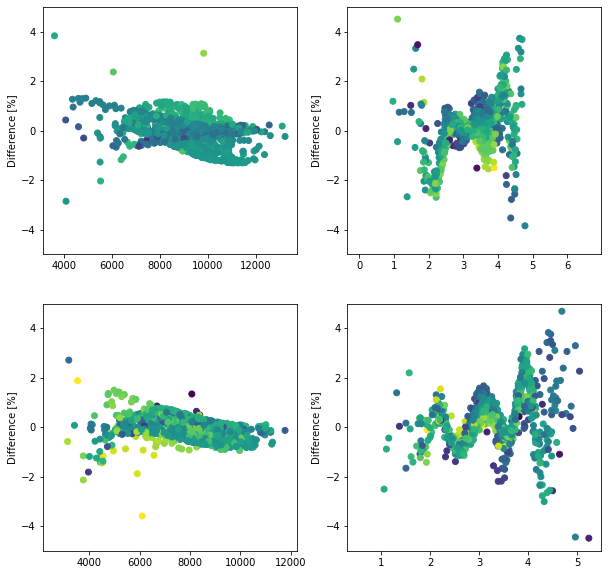

In [16]:
# PLots comparing the results obtained by the classicla method and the ANN one
# ANN is interpolating, while classicla method is looking for a zero.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.scatter(tem, (temNN-tem)/tem*100, c=np.log10(den))
ax2.scatter(np.log10(den), (denNN-den)/den*100, c=tem)
ax3.scatter(tem2, (temNN2-tem2)/tem2*100, c=np.log10(den2))
ax4.scatter(np.log10(den2), (denNN2-den2)/den2*100, c=tem2);
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel('Difference [%]')
    ax.set_ylim(-5, 5)

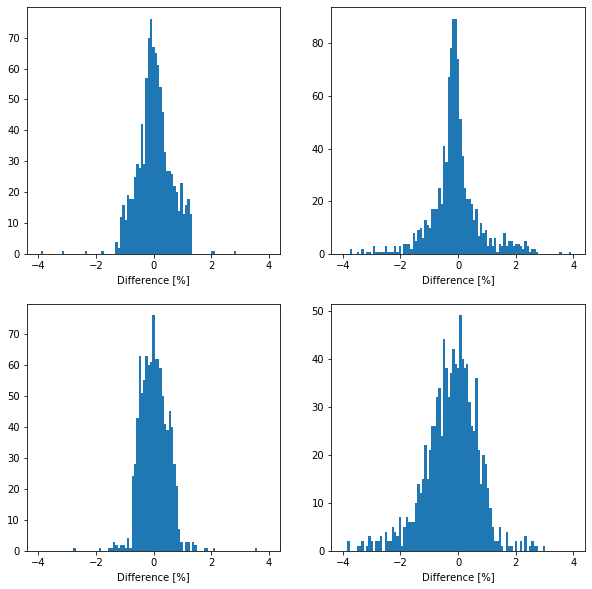

In [17]:
# Histograms of the differences. Not that bad indeed.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist((tem-temNN)/tem*100, bins=np.linspace(-4, 4, 100))
ax2.hist((den-denNN)/den*100, bins=np.linspace(-4, 4, 100));
ax3.hist((tem2-temNN2)/tem2*100, bins=np.linspace(-4, 4, 100))
ax4.hist((den2-denNN2)/den2*100, bins=np.linspace(-4, 4, 100));
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Difference [%]')

In [18]:
# Now we run 4 more ANN to make a mean of the 5 results obtained. Takes time, but if one have 10s of thousands of data, it deserves it.
diags.ANN_inst_kwargs['random_seed'] = 42
temNNb, denNNb = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2b, denNN2b = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 44
temNNc, denNNc = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2c, denNN2c = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 45
temNNd, denNNd = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2d, denNN2d = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
diags.ANN_inst_kwargs['random_seed'] = 46
temNNe, denNNe = diags.getCrossTemDen('[OIII] 4363/5007', '[SII] 6731/6716', rO3, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)
temNN2e, denNN2e = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', rN2, rS2, use_ANN=True, end_den=1e6, start_tem=3e3,limit_res=False)

Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 13405 iterations. Score = 0.998
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 17.7 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1751
Predicting from 2 inputs to 2 outputs using 1751 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 out

/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 12997 iterations. Score = 0.999
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=44, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 16.6 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1751
Predicting from 2 inputs to 2 outputs using 1751 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 out

/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 13177 iterations. Score = 0.999
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=44, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 17.2 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1763
Predicting from 2 inputs to 2 outputs using 1763 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 out

/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 9507 iterations. Score = 0.999
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=45, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 12.2 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1763
Predicting from 2 inputs to 2 outputs using 1763 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outp

/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


RM trained, with 13818 iterations. Score = 0.999
MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 30, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=20000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=46, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time 18.2 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1751
Predicting from 2 inputs to 2 outputs using 1751 data in 0.00 secs.
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 out

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:513: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


In [19]:
# Compute the median of the 5 runs.
temNNm = np.median(np.array((temNN, temNNb, temNNc, temNNd, temNNe)),0)
temNN2m = np.median(np.array((temNN2, temNN2b, temNN2c, temNN2d, temNN2e)),0)
denNNm = np.median(np.array((denNN, denNNb, denNNc, denNNd, denNNe)),0)
denNN2m = np.median(np.array((denNN2, denNN2b, denNN2c, denNN2d, denNN2e)),0)

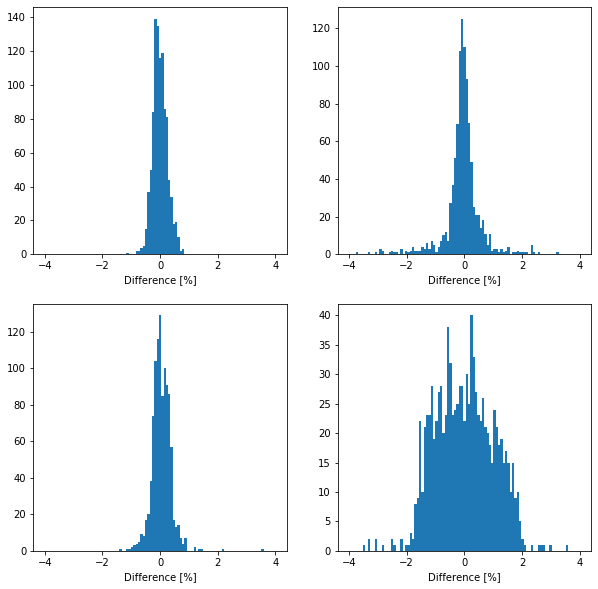

In [20]:
# Histogram of the differences: even better now.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist((tem-temNNm)/tem*100, bins=np.linspace(-4, 4, 100))
ax2.hist((den-denNNm)/den*100, bins=np.linspace(-4, 4, 100));
ax3.hist((tem2-temNN2m)/tem2*100, bins=np.linspace(-4, 4, 100))
ax4.hist((den2-denNN2m)/den2*100, bins=np.linspace(-4, 4, 100));
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Difference [%]')